
# Sistemas Inteligentes 2021-I
## Proyecto Final: Trip Advisor Hotel Reviews
### Integrantes: Juan Sebastián Vargas, Juan Montoya, David Eslava

TripAdvisor es una plataforma web desarrollada en EE.UU la cual brinda reseñas de contenido, recomendaciones, indexado y foros para hoteles, viajes y restaurantes en muchos sitios alrededor del mundo.  
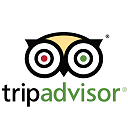  
Creada en Febrero del 2000 por Stephen Kaufer y Langley Steinert, TripAdvisor se posiciona en una buena reputación dentro de los usuarios siendo uno de los sitios preferidos por los turistas a la hora de reservar y consultar distintos hoteles, viajes y restaurantes en el lugar de destino.  
TripAdvisor es una paltaforma en la cual los usuarios retroalimentan la información de los diferentes sitios que visitan a traves de las reseñas que brindan, esta métrica permite tanto para los viajeros fijarse en determinados sitios de interes según las recomendaciones y calidad de servicio; como para las empresas que brindan sus servicios los cuales les permite ganarse una reputación, darse a conocer y también mejorar constantemente el servicio según las opiniones que dan los turistas.  
Enfocandonos en esta métrica y exclusivamente al sector hotelero, TripAdvisor mide la calidad de estos sitios según las opiniones de sus visitantes, permitiendo hacer un comentario y dando una calificación de 1 a 5 estrellas en donde 5 estrellas es considerado un excelente servicio, y 1 estrella la peor calificación e inconformidad con el hotel.  
Tanto para la plataforma como para los hoteleros, es importante identificar que factores influyen en los clientes a la hora de calificar el servicio. Así como también que características son comunes dentro de cada una de las calificaciones.  
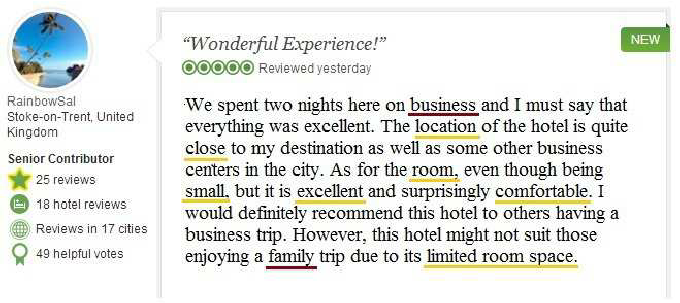

El objetivo de este proyecto es poder crear un sistema inteligente (Red neuronal) que pueda determinar las características principales de las reseñas que se tienen de los hoteles para uno de los 5 rangos de calificación posibles (1 estrellas, 2 estrellas, 3 estrellas, 4 estrellas y 5 estrellas)

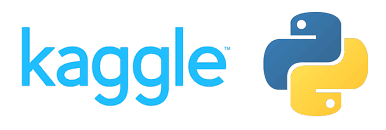

Para poder obtener dicha información, se hace provecho de **Kaggle** un sitio web que facilita la busqueda de información la cual está organizada y preparada para hacer ciencia de datos.  
Para realizar el modelo, se extrae el siguiente [dataset](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews)  el cual contiene la información de 20000 reseñas de hoteles junto con su respectiva calificación.


Pero antes que nada, se inicia la implementación importando las librerías necesarias  
**Nota:** Es altamente recomendado ejecutar este notebook en Google Colab en un entorno de ejecución normal o con TPU para minimizar el tiempo de ejecución y tener una rápida visualización y entrenamiento de las redes neuronales y los datos

In [1]:
# NOTE: It´s Hightly recommended use Collab with a TPU runtime environment
import os
import csv
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #to generate cloud words
from urllib.request import urlretrieve #to download from url 
from tqdm import tqdm #bar progress
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from keras.utils.np_utils import to_categorical
from keras import regularizers

## 1.   Preparación de los datos
Primero se descarga el archivo y se leen los datos.  


In [2]:
if not os.path.isfile('tripadvisor_hotel_reviews.csv'):
    print("Downloading movie simple text file")
    conceptnet_url = 'https://raw.githubusercontent.com/jsmontoyaco/Sistemas-Inteligentes-Proyecto-Final/main/tripadvisor_hotel_reviews.csv'
    urlretrieve(conceptnet_url, 'tripadvisor_hotel_reviews.csv')

In [3]:
remove_punct=str.maketrans('','',string.punctuation)
ys = [] 
cw = []
with open("tripadvisor_hotel_reviews.csv", mode="r", encoding='utf-8', errors='ignore') as f:
  f = csv.reader(f, delimiter=',')
  for l in tqdm(f):
    cw.append(l[0].translate(remove_punct).lower())
    y = int(l[1])
    ys.append(y)
  
ys = np.array(ys)
cw = np.array(cw)

20491it [00:00, 43511.57it/s]


In [4]:
print(ys[0:5])
print(cw[0:5])

[4 2 3 5 5]
['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay 40 parking night  '
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description not suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike k

## 2.  Análisis de Datos
Analicemos los datos de las reseñas, analizando la cantidad y proporción de cada calificación con respecto a las reseñas totales

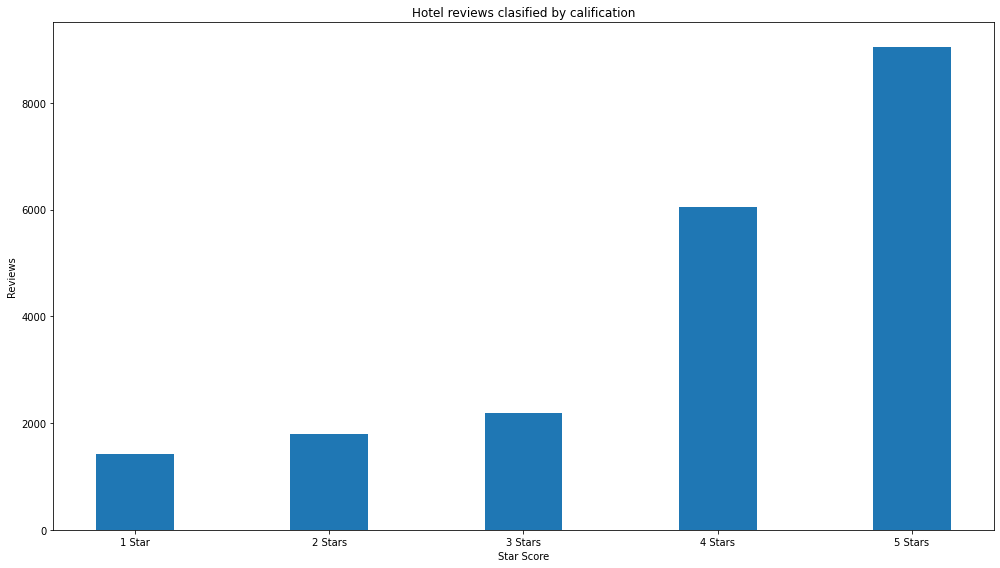

In [5]:
labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
x = np.arange(len(labels))+1
plotdata = np.bincount(np.array(ys))[1:]
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(x, plotdata, width=0.4)
ax.set_ylabel('Reviews')
ax.set_xlabel('Star Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Hotel reviews clasified by calification')
fig.tight_layout()
plt.show()

Mirando la distribución porcentual

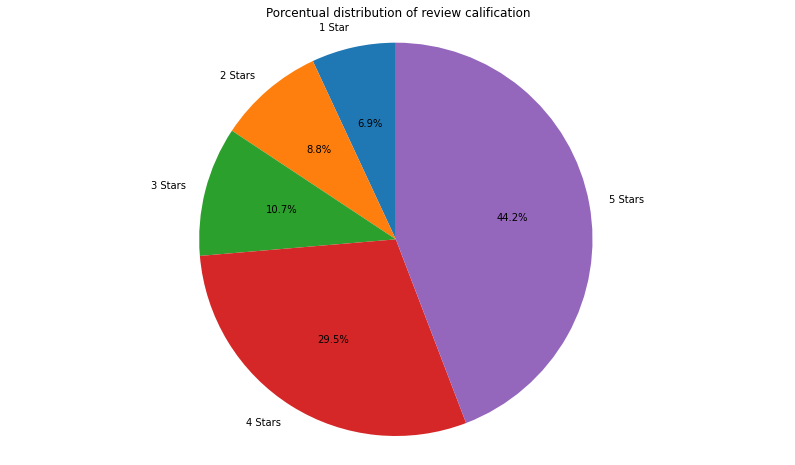

In [6]:
sizes = plotdata/sum(plotdata) *100
explode = (0,0,0,0,0)
fig2, ax2 = plt.subplots(figsize=(14,8))
ax2.pie(sizes, explode= explode, labels= labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Porcentual distribution of review calification')
plt.show()

Como podemos ver, tenemos que en general más de la mitad de las calificaciones dadas por los usuarios son "buenas" estándo en el rango de 4 a 5 estrellas

Ahora el siguiente objetivo es ver qué palabras son frecuentes dentro de las reseñas según su calificación, usando las herramientas gráficas de python se puede hacer una nube de palabras como mejor representación gráfica de la información.

In [7]:
words1s = np.take(cw, np.argwhere(ys==1))
strw1 = ' '.join(str(i) for i in words1s)
words2s = np.take(cw, np.argwhere(ys==2))
strw2 = ' '.join(str(i) for i in words2s)
words3s = np.take(cw, np.argwhere(ys==3))
strw3 = ' '.join(str(i) for i in words3s)
words4s = np.take(cw, np.argwhere(ys==4))
strw4 = ' '.join(str(i) for i in words4s)
words5s = np.take(cw, np.argwhere(ys==5))
strw5 = ' '.join(str(i) for i in words5s)

In [8]:
def cloudwordplot(cloudword, calification):
  # Create and generate a word cloud image:
  wordcloud = WordCloud(width=1400, height=800, contour_color='white', background_color='white').generate(cloudword)

  # Display the generated image:
  plt.figure(figsize=(14,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Palabras más comunes en las reseñas de %1d estrellas' %(calification))
  plt.axis("off")
  plt.show()
 

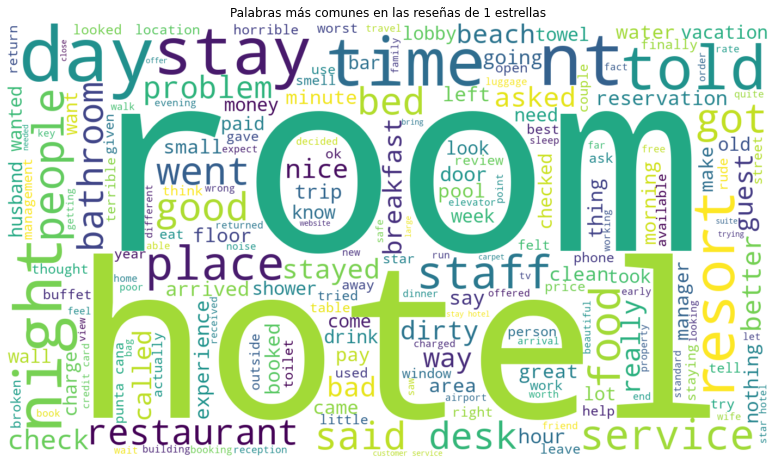

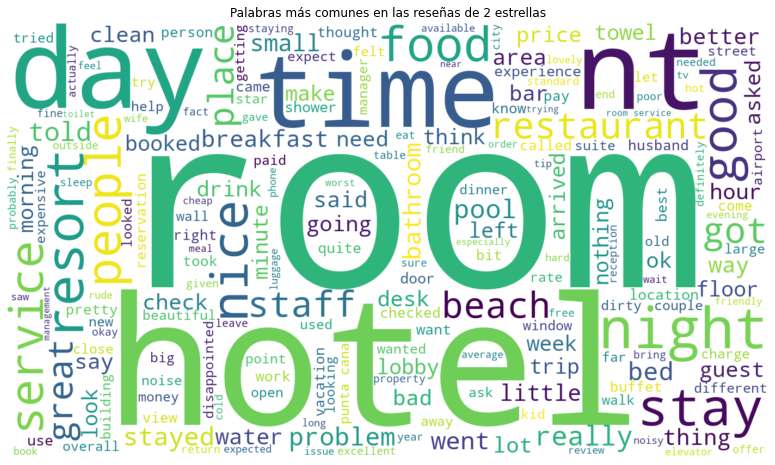

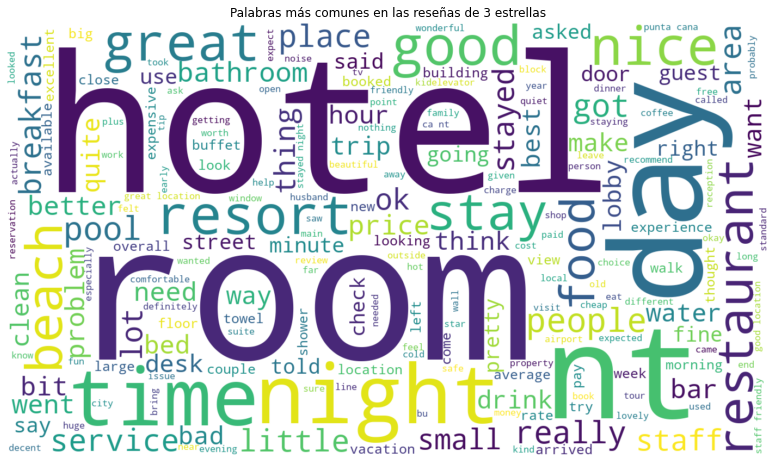

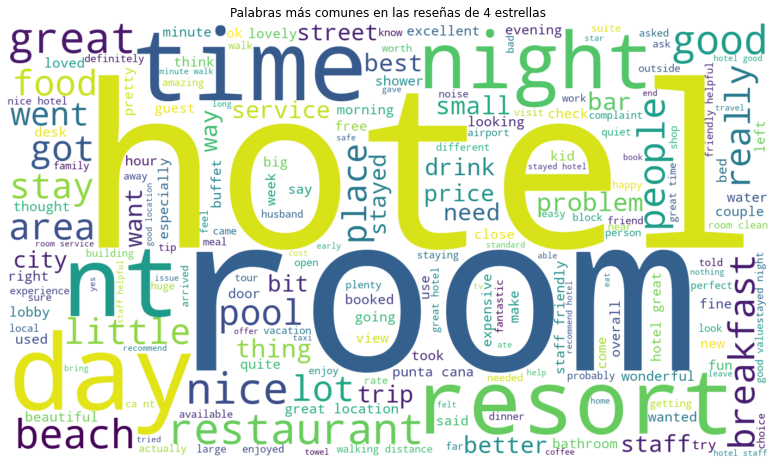

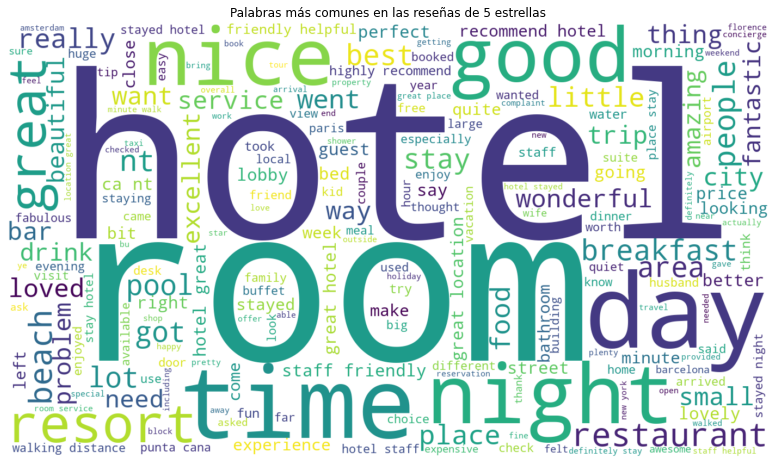

In [9]:
cloudwordplot(strw1,1)
cloudwordplot(strw2,2)
cloudwordplot(strw3,3)
cloudwordplot(strw4,4)
cloudwordplot(strw5,5)

## 3.  Modelamiento
El objetivo es poder predecir con base a una reseña, su respectiva calificación, este tipo de modelos es útil cuando no se tienen los datos etiquetados. Por ejemplo, comentarios en redes sociales los cuales no tienen etiqueta de calificación.  
Para ello se plantea un modelo de red neuronal para el procesamiento de texto, en donde nuestros datos X (features) serán las reseñas y la salida o etiqueta (y, labels) será la calificación [Review, Rating].  

### 3.1 Creación y preentrenamiento del vocabulario de palabras

Para poder realizar la predicción de datos con una red neuronal, se requiere que las palabras sean vectorizadas, es decir, tranformar la palabra en un espacio vectorial con $m$ dimensiones, aquellas palabras que se encuentren vectorialmente cerca nos indicarán que hay cierta similitud o correlación entre ellas. Aquella herramienta que nos permite asignar ese espacio vectorial se conoce como vocabulario o  Word embeddings. Se puede encontrar varios tipos de vocabularios preentrenados y enfocados para distintos entornos. En este caso, usando las herramientas de Scikitlearn, podemos preentrenar un vocabulario con base en el conjunto de datos.

In [10]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv', header= None, names=['Review', 'Rating'])
df.shape

(20491, 2)

*   Función para procesar el texto, respecto a comas, signos de exclamación, etc.

In [11]:
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))

punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" #List of punctuation to remove

def reviewParse(review):
    splitReview = review.split() # Split the review into words
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview]) #Takes the stubborn punctuation out
    return parsedReview # Returns the parsed review
  
def clean_review(review):
    clean_words = []
    splitReview = review.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    clean_review = " ".join(clean_words)
    return clean_review

df["Review"] = df["Review"].apply(reviewParse).apply(clean_review) #Parse all the reviews for their punctuation and add it into a new column

df.head() #Take a peek at the dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms experience hotel monaco seattle goo...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5




*   Creación del tensor de palabras vectorizadas



In [12]:
docs = list(df['Review'])[:9000]
print(len(docs))

9000


In [13]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

*   Se Toman 9.000 muestras del dataset.

In [14]:
X = tfidf_vectorizer_vectors.toarray()
Y = df['Rating'][:9000]

* Muestra del vocabulario preentrenado

In [15]:
tfidf_vectorizer.vocabulary_

{'nice': 10575,
 'hotel': 7678,
 'expensive': 5682,
 'parking': 11649,
 'got': 6894,
 'good': 6856,
 'deal': 4118,
 'stay': 16526,
 'anniversary': 602,
 'arrived': 863,
 'late': 8918,
 'evening': 5506,
 'took': 17645,
 'advice': 240,
 'previous': 13107,
 'reviews': 14704,
 'valet': 18432,
 'check': 2767,
 'quick': 13600,
 'easy': 5074,
 'little': 9205,
 'disappointed': 4552,
 'nonexistent': 10693,
 'view': 18568,
 'room': 14904,
 'clean': 2992,
 'size': 15853,
 'bed': 1457,
 'comfortable': 3215,
 'woke': 19517,
 'stiff': 16594,
 'neck': 10482,
 'high': 7455,
 'pillows': 12252,
 'soundproof': 16188,
 'like': 9125,
 'heard': 7333,
 'music': 10383,
 'night': 10607,
 'morning': 10254,
 'loud': 9350,
 'doors': 4795,
 'opening': 11032,
 'closing': 3064,
 'hear': 7331,
 'people': 12063,
 'talking': 17118,
 'hallway': 7176,
 'maybe': 9768,
 'noisy': 10676,
 'neighbors': 10517,
 'aveda': 1081,
 'bath': 1351,
 'products': 13315,
 'goldfish': 6845,
 'touch': 17699,
 'taken': 17103,
 'advantage': 

### 3.2  Modelado



---



---


*   **Regresión Logística**
Se utiliza un modelo básico y sencillo de machine learning llamado regresión logística, el cual puede aplicarse para esta situación mediante la herramienta de Scikitlearn

In [16]:
SEED = 224 #Used to define the random_state
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
lr.score(X_test, y_test) #accurancy 

0.5761111111111111

In [19]:
y_pred = lr.predict(X_test) #Prediction

In [20]:
confusion_matrix(y_pred,y_test)

array([[ 84,  27,   8,   1,   2],
       [ 28,  39,  25,  10,   0],
       [  6,  20,  24,  14,   0],
       [ 10,  43,  99, 285, 152],
       [ 13,  39,  41, 225, 605]])

In [21]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64       122
           2       0.23      0.38      0.29       102
           3       0.12      0.38      0.18        64
           4       0.53      0.48      0.51       589
           5       0.80      0.66      0.72       923

    accuracy                           0.58      1800
   macro avg       0.46      0.52      0.47      1800
weighted avg       0.64      0.58      0.60      1800



Cómo podemos observar, la implementación del modelo con regresión logística no es muy preciso y poco viable, puesto que Scikitlearn no es capaz de procesar toda la información, a raíz de ello da un índice de exactitud del 58%, el cual no es un indicador confiable para decir que nuestro modelo es acertado y/o adecuado



---



---


***Red Neuronal***

La siguiente implementación de modelado es más compleja pero más efectiva. Las redes neuronales también están diseñadas e implementadas para funcionar en procesamiento de lenguaje natural.



**Es importante tener en cuenta las dimensiones en nuestros datos. La red neuronal hará multiplicaciones de matrices en simultáneo y se debe tener explícito el número de datos que entran y el número que salen.**

In [22]:
X_train.shape

(7200, 20000)

In [23]:
y_train.shape

(7200,)

In [24]:
# Categorizing
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

La función de categorización convierte la salida en un vector del tamaño del número de valores que puede adquirir la etiqueta Y.  
En este ejemplo particular la función categorical creará un arreglo de [n,5], en donde en la posición del valor de la etiqueta - 1 tendrá el valor de 1 y el resto de 0. Ej: $y=3$ -> $y_{\text{categorical}}= [0,0,1,0,0]$

In [25]:
print(y_train[4302])
print('----------')
print(y_train_categorical[0])

5
----------
[0. 0. 0. 0. 0. 1.]


*   **Modelo Red Neuronal**  
la red Neuronal se compondrá por 3 capas, teniendo en las dos primeras la función de rectificación lineal ReLU con 48 filtros, y la última la función softmax, que es una generalización de la función logística.

In [26]:
model = models.Sequential()
model.add(layers.Dense(48, activation='relu', input_shape=(20000,), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01) ) )
model.add(layers.Dense(6, activation='softmax')) # Se quiere predecir que categoría tiene mayor probabilidad

In [27]:
model.compile(optimizer='rmsprop', #optimizer method
              loss='categorical_crossentropy', #loss medition
              metrics=['acc']   
             )

*  Se preparan los datos de prueba y entrenamiento.  
Se seleccionaran mil datos de entrenamiento y prueba

In [28]:
x_val = X_train[:1000]
partial_x_train = X_train[1000:]

y_val = y_train_categorical[:1000]
partial_y_train =  y_train_categorical[1000:]

In [29]:
x_val.shape

(1000, 20000)

* **Fase de entrenamiento**

In [30]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=35,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/35
13/13 [==============================] - 16s 124ms/step - loss: 2.5257 - acc: 0.3271 - val_loss: 2.0074 - val_acc: 0.4060
Epoch 2/35
13/13 [==============================] - 1s 78ms/step - loss: 1.9695 - acc: 0.4176 - val_loss: 1.8824 - val_acc: 0.4060
Epoch 3/35
13/13 [==============================] - 1s 77ms/step - loss: 1.8451 - acc: 0.4276 - val_loss: 1.7831 - val_acc: 0.4060
Epoch 4/35
13/13 [==============================] - 1s 78ms/step - loss: 1.7510 - acc: 0.4246 - val_loss: 1.7081 - val_acc: 0.4060
Epoch 5/35
13/13 [==============================] - 1s 78ms/step - loss: 1.6774 - acc: 0.4271 - val_loss: 1.6518 - val_acc: 0.4060
Epoch 6/35
13/13 [==============================] - 1s 76ms/step - loss: 1.6134 - acc: 0.4286 - val_loss: 1.6089 - val_acc: 0.4060
Epoch 7/35
13/13 [==============================] - 1s 77ms/step - loss: 1.5793 - acc: 0.4222 - val_loss: 1.5764 - val_acc: 0.4060
Epoch 8/35
13/13 [==============================] - 1s 77ms/step - loss: 1.5482 -

* **Interpretación de resultados** 

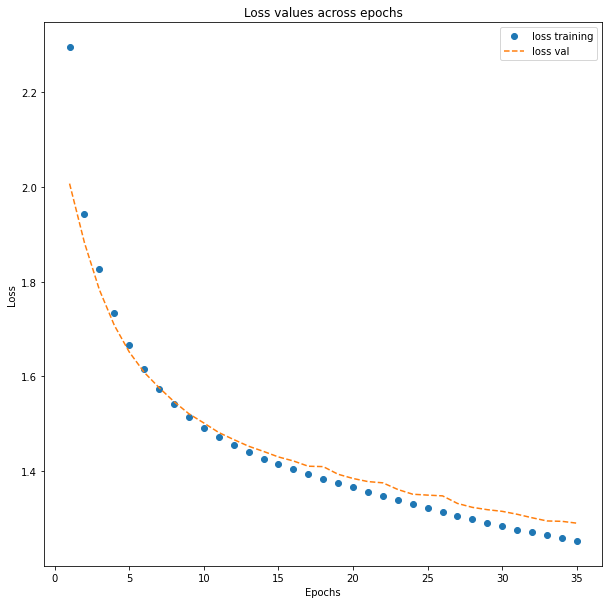

In [31]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,loss_values, 'o',label='loss training')
plt.plot(epoch,val_loss_values, '--',label='loss val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss values across epochs')
plt.legend()
plt.show()

In [32]:
model.evaluate(X_test, y_test_categorical)

57/57 [==============================] - 0s 6ms/step - loss: 1.2846 - acc: 0.4811


[1.284598469734192, 0.4811111092567444]

Para determinar el número de iteraciones adecuadas tenemos que analizar los valores de perdida con respecto a cada iteración.  
Tenemos dos indicadores de pérdida, $val_{\text{loss}}$ que corresponde al valor de costo con respecto a la función de validación cruzada (cross-validation data) mientras que $loss$ es el valor de costo con respecto a la función para los datos de entrenamiento.  
Cómo se puede ver en la gráfica, en la época 29 se obtiene un mínimo local, lo cual indica el menor valor de perdida.  
El índice de exactitud es del 49%, lo cual a comparación del anterior modelo, sigue presentando un bajo nivel de confianza, no obstante la red neuronal permite procesar eficientemente todos los datos y evitar los errores concurridos con el modelo de regresión logística.



---



---

***Red neuronal usando Dropout***

El dropout es una técnica en modelamiento de redes neuronales para reducir el sobreajuste (overfitting) del modelo. Las redes neuronales tienden a hacer sobreajuste reduciendo su capacidad para predecir datos nuevos (no vistos por la red antes) a pesar de tener una alta afinidad con los datos de entrenamiento (como si los aprendiera).

* 1. Modelamiento

In [33]:
## Dropout helps to avoid overfitting
model2 = models.Sequential()
model2.add(layers.Dense(48, activation='relu', input_shape=(20000,)))
model2.add(layers.Dropout(0.8)) 
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax')) # Se quiere predecir que categoría tiene mayor probabilidad

In [34]:
model2.compile(optimizer='rmsprop', # Versión optimizada del descenso del gradiente
              loss='categorical_crossentropy',
              metrics=['acc']   
             )

* 2. Fase de Entrenamiento

In [35]:
history2 = model2.fit(partial_x_train,
                   partial_y_train,
                   epochs=35,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/35
13/13 [==============================] - 3s 98ms/step - loss: 1.7636 - acc: 0.2918 - val_loss: 1.6692 - val_acc: 0.4060
Epoch 2/35
13/13 [==============================] - 1s 73ms/step - loss: 1.6410 - acc: 0.3790 - val_loss: 1.5532 - val_acc: 0.4060
Epoch 3/35
13/13 [==============================] - 1s 74ms/step - loss: 1.5502 - acc: 0.4069 - val_loss: 1.4676 - val_acc: 0.4060
Epoch 4/35
13/13 [==============================] - 1s 73ms/step - loss: 1.4828 - acc: 0.4016 - val_loss: 1.4149 - val_acc: 0.4060
Epoch 5/35
13/13 [==============================] - 1s 74ms/step - loss: 1.4327 - acc: 0.4202 - val_loss: 1.3714 - val_acc: 0.4060
Epoch 6/35
13/13 [==============================] - 1s 73ms/step - loss: 1.4025 - acc: 0.4150 - val_loss: 1.3303 - val_acc: 0.4060
Epoch 7/35
13/13 [==============================] - 1s 75ms/step - loss: 1.3631 - acc: 0.4126 - val_loss: 1.2951 - val_acc: 0.4060
Epoch 8/35
13/13 [==============================] - 1s 74ms/step - loss: 1.3102 - a

* 3. Validación de datos

In [36]:
y_pred = model2.predict(X_test) # Con X de test.
y_pred #Y predicted data without proccesing

array([[2.8726839e-07, 4.4495227e-06, 1.1178805e-05, 2.4484153e-04,
        2.5648490e-02, 9.7409081e-01],
       [1.0500459e-03, 5.4218052e-03, 2.6432980e-02, 7.3762111e-02,
        7.7980608e-01, 1.1352702e-01],
       [1.1312408e-02, 2.5509453e-01, 1.9966298e-01, 2.7409208e-01,
        1.1211484e-01, 1.4772314e-01],
       ...,
       [1.8867561e-07, 3.7361103e-06, 7.2882240e-06, 1.6534507e-04,
        1.5772326e-02, 9.8405117e-01],
       [3.6710936e-03, 5.1751815e-02, 8.4943764e-02, 1.8408288e-01,
        3.4492344e-01, 3.3062702e-01],
       [5.9995975e-05, 1.1401508e-03, 1.3064309e-03, 7.6723481e-03,
        5.2906647e-02, 9.3691444e-01]], dtype=float32)

Descategorizando $y_{\text{Predicted}}$

In [37]:
y_pred_uncat = []

for i in range( len(y_pred) ):
  y_pred_uncat.append( np.argmax(y_pred[i]) )

print(y_pred_uncat) #Labeled Y data

[5, 4, 3, 5, 3, 5, 1, 3, 5, 4, 1, 5, 4, 4, 4, 2, 4, 5, 1, 2, 1, 1, 5, 5, 4, 3, 5, 5, 5, 3, 4, 4, 4, 5, 5, 3, 5, 4, 3, 4, 5, 1, 5, 1, 4, 3, 3, 3, 4, 5, 5, 4, 4, 4, 5, 1, 1, 5, 4, 5, 5, 4, 3, 5, 5, 3, 1, 5, 3, 4, 4, 3, 5, 5, 5, 2, 5, 2, 5, 4, 1, 2, 1, 5, 3, 4, 4, 5, 5, 3, 5, 4, 4, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 4, 1, 5, 4, 1, 4, 5, 5, 5, 4, 5, 5, 3, 5, 5, 4, 4, 5, 5, 5, 4, 5, 1, 4, 5, 5, 4, 5, 5, 5, 5, 1, 5, 4, 5, 5, 3, 4, 5, 5, 3, 5, 5, 1, 1, 5, 4, 5, 5, 5, 1, 4, 3, 5, 4, 5, 4, 4, 5, 5, 5, 1, 4, 5, 5, 3, 1, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 2, 5, 3, 1, 5, 1, 2, 4, 5, 5, 5, 5, 5, 1, 5, 5, 4, 4, 4, 5, 5, 2, 5, 3, 5, 5, 5, 5, 3, 2, 5, 5, 4, 4, 4, 4, 4, 3, 5, 5, 4, 5, 5, 4, 4, 1, 3, 5, 1, 5, 5, 1, 4, 5, 5, 4, 5, 3, 5, 3, 1, 5, 5, 2, 5, 4, 5, 2, 4, 1, 3, 5, 5, 5, 2, 4, 5, 5, 5, 4, 4, 3, 1, 5, 4, 5, 3, 4, 5, 4, 5, 4, 5, 5, 5, 4, 5, 4, 1, 3, 5, 4, 5, 5, 4, 5, 1, 5, 3, 5, 5, 4, 4, 3, 5, 3, 4, 3, 5, 5, 1, 4, 5, 1, 2, 4, 5, 4, 5, 5, 4, 2, 4, 4, 5, 1, 4, 5, 5, 2, 3, 1, 5, 3, 5, 5, 4, 5, 5, 5, 5, 

Estandarizamos las salidas para que no tengan llaves diferentes

In [38]:
y_pred = pd.DataFrame(y_pred_uncat)
y_test_arr = np.array(y_test)
y_t = pd.DataFrame(y_test_arr)

* 4. Interpretación de resultados

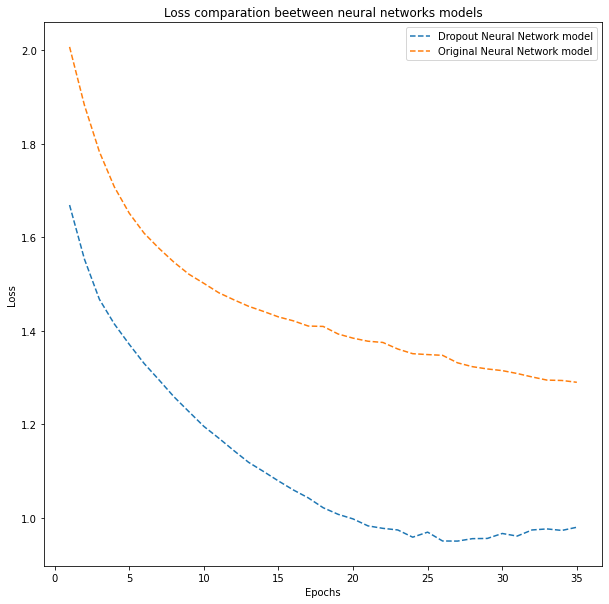

In [39]:
history_dict = history.history

val_loss_values = history_dict['val_loss']
val_loss_values2 = history2.history['val_loss']
loss_values = history_dict['loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,val_loss_values2, '--',label='Dropout Neural Network model')
plt.plot(epoch,val_loss_values, '--',label='Original Neural Network model')
plt.title('Loss comparation beetween neural networks models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
confusion_matrix(y_pred, y_t) # Y predicted and Y_test standarized

array([[ 94,  41,  16,   3,   1],
       [ 23,  29,  16,   3,   0],
       [ 15,  52,  52,  34,   4],
       [  3,  29,  86, 277, 174],
       [  6,  17,  27, 218, 580]])

In [41]:
print(classification_report(y_pred,y_t)) # Y predicted and Y_test standarized

              precision    recall  f1-score   support

           1       0.67      0.61      0.64       155
           2       0.17      0.41      0.24        71
           3       0.26      0.33      0.29       157
           4       0.52      0.49      0.50       569
           5       0.76      0.68      0.72       848

    accuracy                           0.57      1800
   macro avg       0.48      0.50      0.48      1800
weighted avg       0.61      0.57      0.59      1800



Cómo se puede apreciar en la gráfica, la red neuronal con Dropout muestra un notable desempeño con respecto a la red neuronal original, los valores de perdida se reducen notablemente, además de obtiene un índice de exactitud más elevado, 62%, el cual es un factor que da mucha más confianza con respecto a la red original, y al usar dropout, podemos asegurar que el modelo no presentó un sobreajuste que haya alterado los índices de exactitud.